In [1]:
"""
July 7, 2020

Adding another blob
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
# Independent variables
# redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))
redshifts = np.sort(np.array([0.10165, 0.25,    0.35 ,   0.45,    0.575,   0.725,   0.875,   0.9,     ]))#1.125, 1.65,    1.75,    2.25,    2.5,   ]))#  2.75,    3.5,  ]))


Ms = np.linspace(7, 12, 60)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

# blob 2: the sfrd
blob_n2 = ['galaxy_sfrd']
blob_i2 = [('z', redshifts)]
blob_f2 = ['SFRD']

In [3]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [4]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

In [5]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')
# ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

#to actually use
# ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

# ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

# ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

# ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
# ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [6]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [7]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

In [8]:
# base_pars.update(guesses)
# pop = ares.populations.GalaxyPopulation(**base_pars)

# z = 1

# smf = pop.StellarMassFunction(z, Ms)
# pl.semilogy(Ms, smf, label='guess')
# data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

# pl.legend()
# pl.show()

In [9]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [10]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 20

fitter.jitter = [0.1] * len(fitter.parameters)

fitter.guesses = guesses

# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.017459575584079293 to 0.058623327623095176
# Fixing position of walker 11 (parameter pq_func_par0[1])
# Moved from -0.19588829889921017 to 0.08773721375308566
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.011947179569037101 to 0.0027499614097183447
# Fixing position of walker 18 (parameter pq_func_par0[1])
# Moved from -0.03194927487850957 to 0.18720268068256343
# Fixing position of walker 19 (parameter pq_func_par0[1])
# Moved from -0.010286514457794129 to 0.0027499614097183447


In [ ]:
fitter.run('MCMC_files/blob_test2', burn=5, steps=40, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Fri Jul 10 15:15:24 2020
[1.01982945e-05 1.07069810e-05 1.12410405e-05 ... 1.66887593e+15
 1.69333140e+15 1.71814524e+15]
[6.17275130e-06 6.48527063e-06 6.81361246e-06 ... 1.76060814e+15
 1.78687487e+15 1.81353348e+15]
[4.40172778e-06 4.62680679e-06 4.86339505e-06 ... 1.81659710e+15
 1.84398544e+15 1.87178670e+15]
[3.13981094e-06 3.30195037e-06 3.47246266e-06 ... 1.86855655e+15
 1.89699676e+15 1.92586983e+15]
[2.05931588e-06 2.16696096e-06 2.28023288e-06 ... 1.92854927e+15
 1.95821724e+15 1.98834161e+15]
[1.24238836e-06 1.30827421e-06 1.37765409e-06 ... 1.99424697e+15
 2.02527599e+15 2.05678780e+15]
[7.50232138e-07 7.90588257e-07 8.33115192e-07 ... 2.05405326e+15
 2.08633659e+15 2.11912732e+15]
[6.89803671e-07 7.26996652e-07 7.66195012e-07 ... 2.06350894e+15
 2.09599194e+15 2.12898628e+15]
[1.01982945e-05 1.07069810e-05 1.12410405e-05 ... 1.66887593e+15
 1.69333140e+15 1.71814524e+15]
[6.17275130e-06 6.48527063e-06 6.813

In [24]:
# anl = ares.analysis.ModelSet('MCMC_files/blob_test1')

# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
anl = ares.analysis.ModelSet('..\Cedar\savedFits/smf_13_07_13-22_0.5')
# smf_10_07_12:21


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ..\Cedar\savedFits/                                                                    ####
#### prefix      : smf_13_07_13-22_0.5                                                                    ####
#### N-d         : 8                                                                                      ####


# Loading ..\Cedar\savedFits/smf_13_07_13-22_0.5.dd*.chain.pkl...
# Loaded ..\Cedar\savedFits/smf_13_07_13-22_0.5.dd*.chain.pkl in 0.093 s.
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0000.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0001.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0002.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0003.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0004.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0005.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0006.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0007.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0008.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0009.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0010.blob_2d.galaxy_smf.pkl
# 

C:\Users\Emma\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


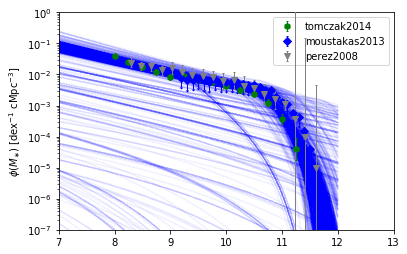

In [25]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [26]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]',

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.164292e+00
pq_func_par2[0]: 3.945241e-02
pq_func_par0[1]: 1.623619e-01
pq_func_par2[1]: -7.732377e-01
pq_func_par0[2]: 6.193081e-01
pq_func_par2[2]: -2.544338e-01
pq_func_par0[3]: 1.190310e+01
pq_func_par2[3]: 2.444613e-01


0 of 7200 chain elements ignored because of chain links with inf's/nan's.


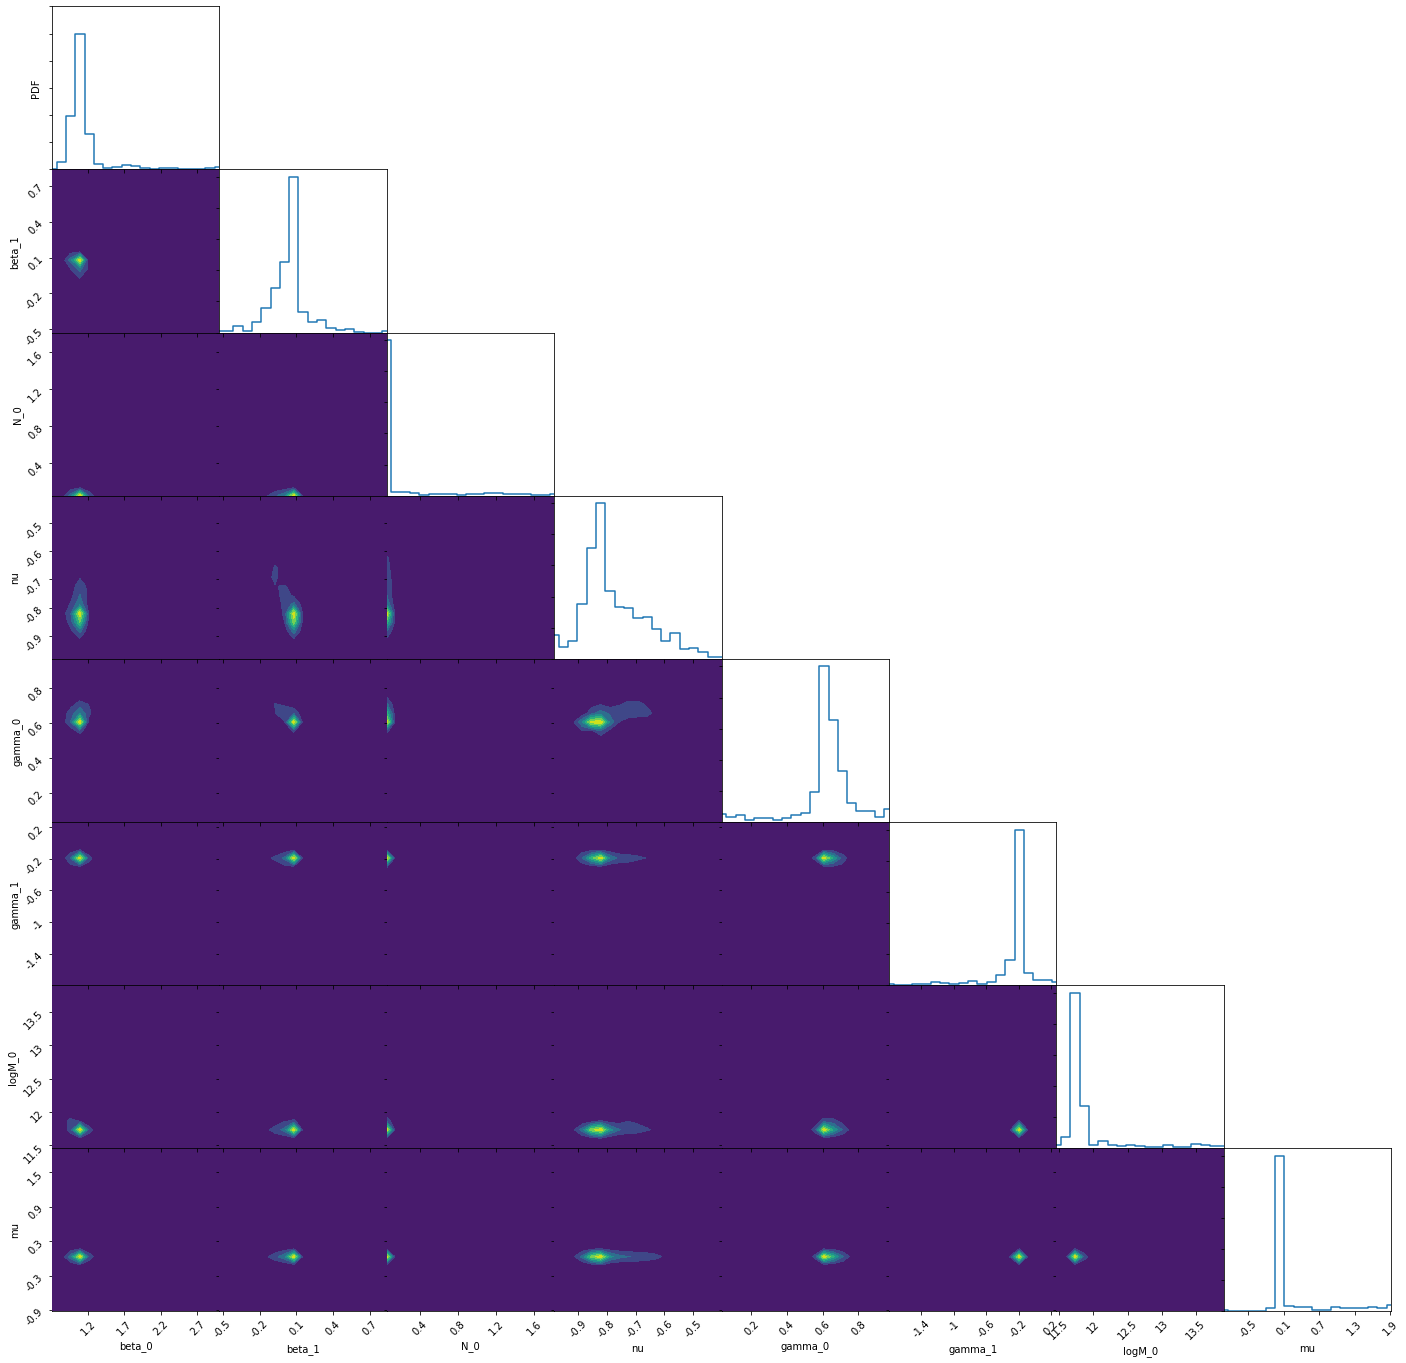

In [27]:

trig = anl.TrianglePlot(pars=params)

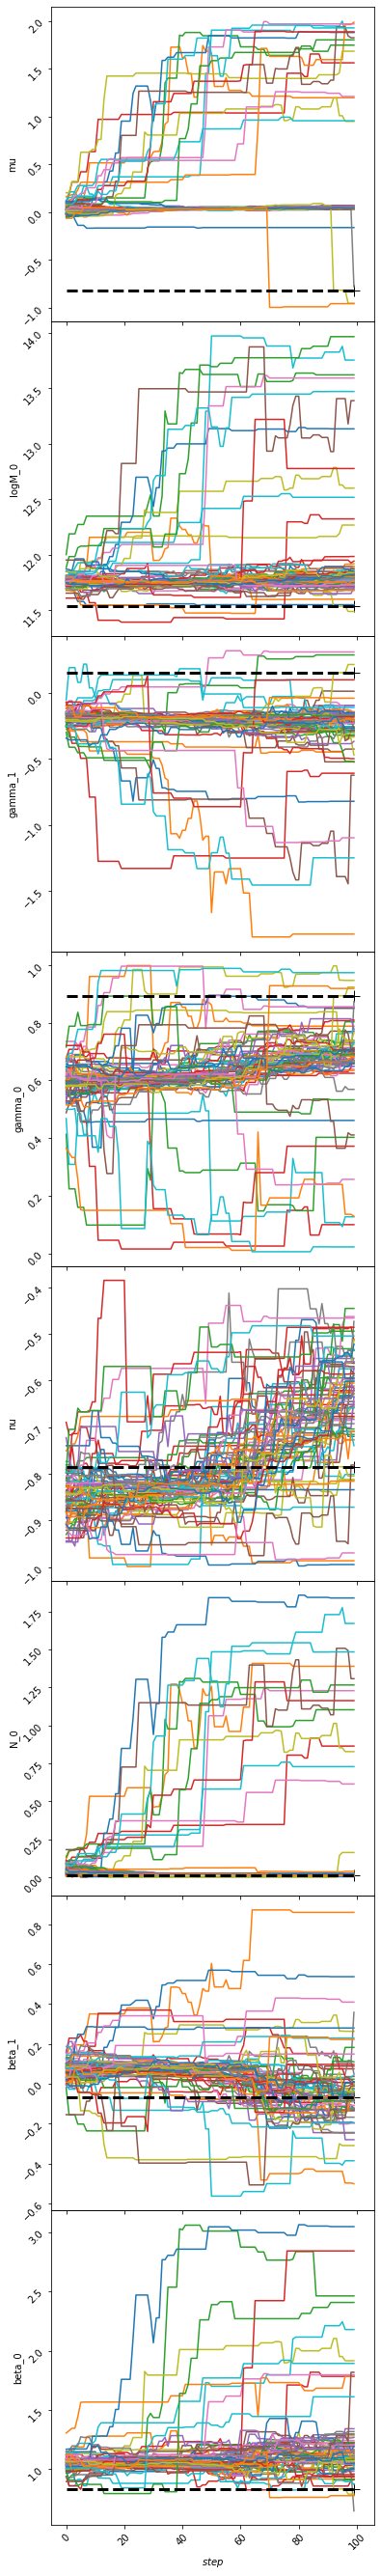

In [28]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [29]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 0.8286053410565382,
 'pq_func_par2[0]': -0.06972278454691083,
 'pq_func_par0[1]': 0.012055269801406334,
 'pq_func_par2[1]': -0.784639613636338,
 'pq_func_par0[2]': 0.892896336427895,
 'pq_func_par2[2]': 0.1543948926204906,
 'pq_func_par0[3]': 11.536952469449558,
 'pq_func_par2[3]': -0.8167011743402004}

In [30]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.164292e+00
pq_func_par2[0]: 3.945241e-02
pq_func_par0[1]: 1.623619e-01
pq_func_par2[1]: -7.732377e-01
pq_func_par0[2]: 6.193081e-01
pq_func_par2[2]: -2.544338e-01
pq_func_par0[3]: 1.190310e+01
pq_func_par2[3]: 2.444613e-01


In [31]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [32]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(0.8286053410565382, array([ 0.38451281, -0.17682602]))
(-0.06972278454691083, array([0.18034806, 0.00760029]))
(0.012055269801406334, array([ 0.15142633, -0.00743582]))
(-0.784639613636338, array([0.12845127, 0.0811081 ]))
(0.892896336427895, array([-0.17792545,  0.32018163]))
(0.1543948926204906, array([-0.31163442,  0.44651781]))
(11.536952469449558, array([ 0.36768454, -0.18517577]))
(-0.8167011743402004, array([ 1.24184868, -0.84470192]))


In [33]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 0.8286053410565382, 'pq_func_par2[0]': -0.06972278454691083, 'pq_func_par0[1]': 0.012055269801406334, 'pq_func_par2[1]': -0.784639613636338, 'pq_func_par0[2]': 0.892896336427895, 'pq_func_par2[2]': 0.1543948926204906, 'pq_func_par0[3]': 11.536952469449558, 'pq_func_par2[3]': -0.8167011743402004}


[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


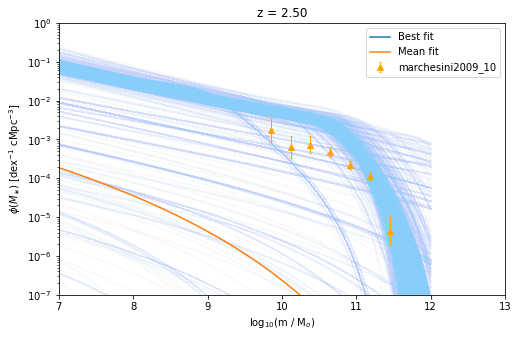

In [36]:
z = 2.5

fig, ax = pl.subplots(figsize=(8, 5))
Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.xlabel("log$_{10}$(m / M$_o$)")
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0000.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0001.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0002.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0003.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0004.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0005.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0006.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0007.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0008.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0009.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0010.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd0011.blob_1d.galaxy_sfrd.pkl
# Loaded ..\Cedar\savedFits\smf_13_07_13-22_0.5.dd00

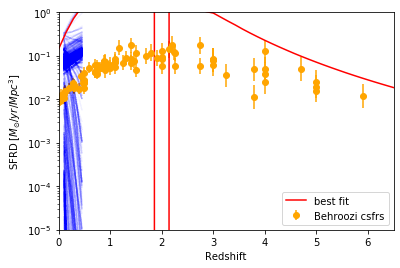

In [35]:
Zs = np.linspace(0, 7, 50)

import UsefulHODFunctions as UHF
csfrs, err = UHF.getCsfrsData()

ax = anl.ReconstructedFunction('galaxy_sfrd', ivar=None, samples='all', color='b', alpha=0.01)

SFRD_mod = pop_best.SFRD(Zs)
# print(SFRD_mod)

ax.semilogy(Zs, SFRD_mod, label="best fit", color='r')

ax.errorbar(csfrs[0], 10**csfrs[1], yerr=[err[0], err[1]], ls="", marker="o", color="orange", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.ylim(1e-5, 1e0)
pl.xlim(0, 6.5)

pl.show()